In [1]:
import pandas as pd
import numpy as np
import re
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
font_path = r'D:\Font\Pretendard-1.3.9\public\variable\PretendardVariable.ttf'
font_prop = fm.FontProperties(fname=font_path)
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False   # 음수 부호가 올바르게 표시되도록 설정

In [2]:
from get_data import get_kosis_data

gkd = get_kosis_data

In [3]:
job = gkd("업종별")
age = gkd("연령별")
dis = gkd("재해정도")
time = gkd("시간별")
career = gkd("입사근속기간별")
type = gkd("발생형태별")
mag = gkd("규모별")

In [4]:
job

,기준년도,산업,항목,값,단위
0,2017,총계,사업장수,2507364.00,개소
1,2018,총계,사업장수,2654107.00,개소
2,2019,총계,사업장수,2680874.00,개소
3,2020,총계,사업장수,2719308.00,개소
4,2021,총계,사업장수,2876635.00,개소
...,...,...,...,...,...
1999,2019,금융 및 보험업,사망만인율,0.15,‱
2000,2020,금융 및 보험업,사망만인율,0.20,‱
2001,2021,금융 및 보험업,사망만인율,0.23,‱
2002,2022,금융 및 보험업,사망만인율,0.20,‱


In [27]:
dis.groupby(['산업', '재해정도'])['값'].mean().reset_index().sort_values('값', ascending=False)

,산업,재해정도,값
630,총계,요양재해자,114233.000000
135,기타의 사업,요양재해자,42237.857143
627,총계,91~180일,36948.000000
623,총계,29~90일,33010.857143
571,제조업,요양재해자,29579.142857
...,...,...,...
637,출판·인쇄·제본업,분류불능,0.000000
485,임업,분류불능,0.000000
460,의약품 및 화장품향료 제조업,사망자,0.000000
601,철도·궤도 및 삭도운수업,8~14일,0.000000


In [5]:
job_mag = job[(job['항목'] == '사업장수') & (job['산업'] != '총계')]  
job_emp = job[(job['항목'] == '근로자수') & (job['산업'] != '총계')]
job_inj = job[(job['항목'] == '요양재해자수') & (job['산업'] != '총계')]
job_injrate = job[(job['항목'] == '요양재해율') & (job['산업'] != '총계')]
job_death = job[(job['항목'] == '사망자수') & (job['산업'] != '총계')]
job_deathrate = job[(job['항목'] == '사망만인율') & (job['산업'] != '총계')]

In [6]:
job_mag.info()

<class 'pandas.core.frame.DataFrame'>
Index: 327 entries, 42 to 1968
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   기준년도    327 non-null    object 
 1   산업      327 non-null    object 
 2   항목      327 non-null    object 
 3   값       327 non-null    float64
 4   단위      327 non-null    object 
dtypes: float64(1), object(4)
memory usage: 15.3+ KB


In [33]:
job_mag_grp = job_mag.groupby('산업')['값'].mean().reset_index().sort_values('값', ascending=False).rename(columns={'값': '사업장수'})
job_emp_grp = job_emp.groupby('산업')['값'].mean().reset_index().sort_values('값', ascending=False).rename(columns={'값': '근로자수'})
job_injrate_grp = job_injrate.groupby('산업')['값'].mean().reset_index().sort_values('값', ascending=False).rename(columns={'값': '요양재해율'})
job_deathrate_grp = job_deathrate.groupby('산업')['값'].mean().reset_index().sort_values('값', ascending=False).rename(columns={'값': '사망만인율'})

job_grp = pd.merge(job_mag_grp, job_emp_grp, on='산업', how='left')
job_grp = pd.merge(job_grp, job_injrate_grp, on='산업', how='left')
job_grp = pd.merge(job_grp, job_deathrate_grp, on='산업', how='left')
job_grp['한 사업장당 근로자수(열 명)'] = job_grp['근로자수'] / job_grp['사업장수'] / 10

In [34]:
job_grp

,산업,사업장수,근로자수,요양재해율,사망만인율,한 사업장당 근로자수(열 명)
0,기타의 사업,1.821596e+06,1.072414e+07,0.390000,0.381429,0.588722
1,도소매·음식·숙박업,9.191145e+05,3.389816e+06,0.602500,0.345000,0.368813
2,도·소매 및 소비자용품수리업,5.085323e+05,2.020312e+06,0.336667,0.293333,0.397283
3,전문·보건·교육·여가관련서비스업,4.538892e+05,3.999118e+06,0.232500,0.185000,0.881078
4,제조업,3.931121e+05,4.044985e+06,0.731429,1.188571,1.028965
...,...,...,...,...,...,...
78,철도·궤도 및 삭도운수업,2.760000e+02,5.872800e+04,0.190000,1.870000,21.278261
79,시멘트제조업,2.440000e+02,7.243000e+03,0.680000,1.380000,2.968443
80,주한미군,1.754286e+02,2.125757e+04,0.195714,0.327143,12.117508
81,석탄광업 및 채석업,6.071429e+01,2.617000e+03,98.360000,1506.611429,4.310353


In [35]:
job_grp[job_grp['산업'].str.contains('석회')]

,산업,사업장수,근로자수,요양재해율,사망만인율,한 사업장당 근로자수(열 명)
73,석회석·금속·비금속광업 및 기타광업,1004.0,8024.142857,4.491429,51.184286,0.799217


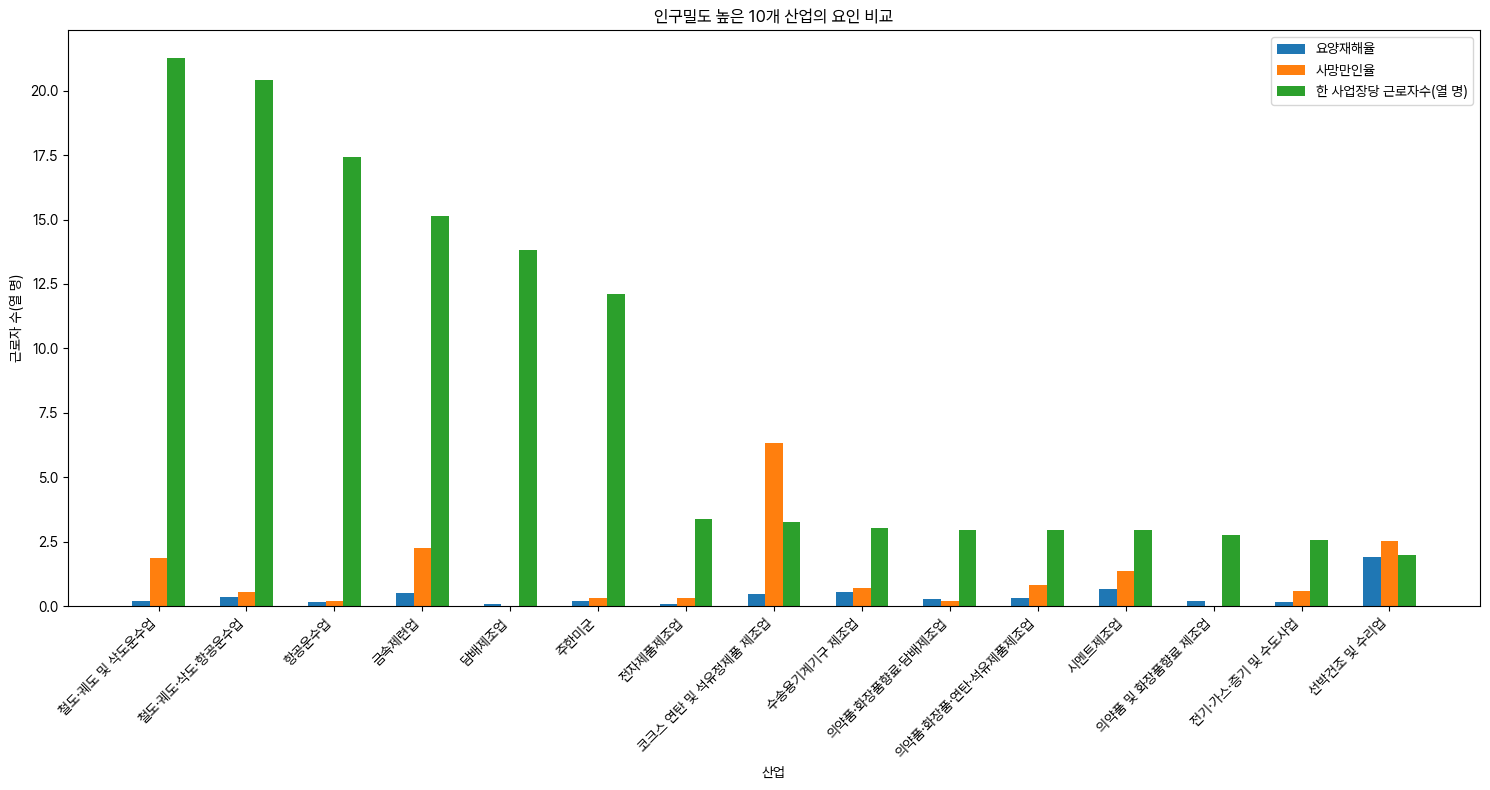

In [ ]:
exp_list = ['석탄광업 및 채석업', '광업', '석회석·금속·비금속광업 및 기타광업']

top_industries = job_grp[~job_grp['산업'].isin(exp_list)].nlargest(15, '한 사업장당 근로자수(열 명)')


fig, ax = plt.subplots(figsize=(15, 8))

# 산업별 바 차트 
x = range(len(top_industries))
width = 0.2

ax.bar(x, top_industries['요양재해율'], width, label='요양재해율')
ax.bar([p + width for p in x], top_industries['사망만인율'], width, label='사망만인율')
ax.bar([p + width*2 for p in x], top_industries['한 사업장당 근로자수(열 명)'], width, label='한 사업장당 근로자수(열 명)')

ax.set_xticks([p + width for p in x])
ax.set_xticklabels(top_industries['산업'], rotation=45, ha='right')

ax.set_xlabel('산업')
ax.set_ylabel('근로자 수(열 명)')
ax.set_title('인구밀도 높은 10개 산업의 요인 비교')
ax.legend()

plt.tight_layout()
plt.show()